 CNN model trained on spectogram images 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display
import random
import warnings
import os
from PIL import Image
import pathlib
import csv
from matplotlib import cm
# sklearn Preprocessing
from sklearn.model_selection import train_test_split
#Keras
import keras
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam



In [ ]:
song_dir =os.listdir('/content/drive/My Drive/RP/genres')
dataset_path ='/content/drive/My Drive/RP/Data.csv'
image_dir='/content/drive/MyDrive/RP/img_data/'
train_dir=os.listdir('/content/drive/My Drive/RP/data/train')
val_dir=os.listdir('/content/drive/My Drive/RP/data/val')


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255, # rescale all pixel values from 0-255, so aftre this step all our pixel values are in range (0,1)
        shear_range=0.2, #to apply some random tranfromations
        zoom_range=0.2, #to apply zoom
        horizontal_flip=True) # image will be flipped horiz

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_set = train_datagen.flow_from_directory(
        '/content/drive/My Drive/RP/data/train',
        target_size=(224, 224),
        #batch_size=32,
        class_mode='categorical',
        shuffle = False)
test_set = test_datagen.flow_from_directory(
        '/content/drive/My Drive/RP/data/val',
        target_size=(224, 224),
        #batch_size=32,
        class_mode='categorical',
        shuffle = False )


Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [ ]:
#Transfer learning: The weights in the conv base are kept fixed but the weights in the feed-forward network
#are allowed to be tuned to predict the correct genre label

vgg_model=VGG16(include_top=True,weights="imagenet",input_shape=(224,224,3),pooling="avg")

#top=true cuz we use output layers of model as it is

553467904/553467096 [==============================] - 3s 0us/step


In [ ]:
#not be training the weights of the first 16 layers and use it as it is
for layer in vgg_model.layers[:16]:
    layer.trainable=False

In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from keras.models import Model
X= vgg_model.layers[-2].output
predictions = Dense(10, activation="softmax")(X)
model_final = Model(vgg_model.input,predictions)

In [ ]:
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:

model_final.compile(optimizer=Adam(lr=1e-5),loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
from keras.callbacks import EarlyStopping
#early_stopping_monitor = EarlyStopping(patience=5)
epochs=100
batch_size=32
history = model_final.fit(train_set,validation_data=test_set,epochs=epochs,batch_size=batch_size)

Epoch 1/100
25/25 [==============================] - 351s 14s/step - loss: 3.2557 - accuracy: 0.0116 - val_loss: 2.8151 - val_accuracy: 0.1000
Epoch 2/100
25/25 [==============================] - 14s 541ms/step - loss: 3.2329 - accuracy: 0.0029 - val_loss: 2.4332 - val_accuracy: 0.1000
Epoch 3/100
25/25 [==============================] - 14s 541ms/step - loss: 2.5159 - accuracy: 0.1194 - val_loss: 2.2652 - val_accuracy: 0.2200
Epoch 4/100
25/25 [==============================] - 14s 541ms/step - loss: 2.5207 - accuracy: 0.1041 - val_loss: 2.1964 - val_accuracy: 0.2450
Epoch 5/100
25/25 [==============================] - 14s 542ms/step - loss: 2.2626 - accuracy: 0.2306 - val_loss: 2.0406 - val_accuracy: 0.3400
Epoch 6/100
25/25 [==============================] - 14s 541ms/step - loss: 2.3414 - accuracy: 0.1840 - val_loss: 1.9021 - val_accuracy: 0.3650
Epoch 7/100
25/25 [==============================] - 14s 541ms/step - loss: 2.0302 - accuracy: 0.3248 - val_loss: 1.7856 - val_accuracy: 

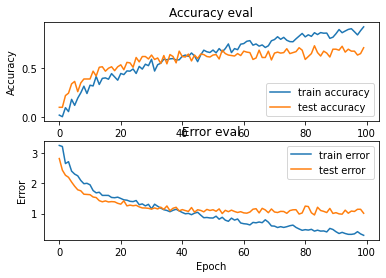

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

plot_history(history)

Predicitons

In [ ]:
test_set.reset()
pred = model_final.predict_generator(test_set, steps=50, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions = predictions[:200]
filenames=test_set.filenames

print(len(filenames), len(predictions))

50/50 [==============================] - 1s 24ms/step
200 200


In [ ]:
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("prediction_results.csv",index=False)

In [ ]:
pd.read_csv('prediction_results.csv')

,Filename,Predictions
0,blues/blues00013.png,blues
1,blues/blues00021.png,blues
2,blues/blues00026.png,blues
3,blues/blues00039.png,jazz
4,blues/blues00042.png,blues
...,...,...
195,rock/rock00084.png,rock
196,rock/rock00088.png,metal
197,rock/rock00090.png,blues
198,rock/rock00093.png,metal


In [ ]:
#true labels
label_index=test_generator.classes
true_label=[labels[i] for i in label_index]
print(labels)

{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


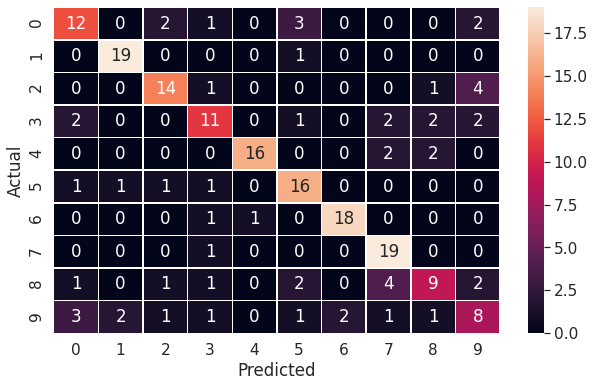

In [ ]:
from sklearn.metrics import confusion_matrix,auc,classification_report
import seaborn as sn

#confusion matrix
mat=confusion_matrix(true_label,predictions)

df=pd.DataFrame(mat,index=list(test_generator.class_indices),columns=list(test_generator.class_indices))
plt.figure(figsize=(10,6))
sn.set(font_scale=1.4)
sn.heatmap(mat,annot=True,linewidths=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:

print (classification_report(true_label,predictions))

              precision    recall  f1-score   support

       blues       0.63      0.60      0.62        20
   classical       0.86      0.95      0.90        20
     country       0.74      0.70      0.72        20
       disco       0.61      0.55      0.58        20
      hiphop       0.94      0.80      0.86        20
        jazz       0.67      0.80      0.73        20
       metal       0.90      0.90      0.90        20
         pop       0.68      0.95      0.79        20
      reggae       0.60      0.45      0.51        20
        rock       0.44      0.40      0.42        20

    accuracy                           0.71       200
   macro avg       0.71      0.71      0.70       200
weighted avg       0.71      0.71      0.70       200

